In [1]:
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import requests
import time

In [2]:
# data = pd.read_csv('test.csv')
# data.head()

# Make a GET request to the API
url = 'http://localhost/smartpolicesystem/backend/api/v1/incident'
max_retries = 3
retry_delay = 1 

for _ in range(max_retries):
    response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    if response.status_code == 200:
        api_response = response.json()
        if 'data' in api_response:
            data = pd.DataFrame(api_response['data'])  # Use correct key access
            break
        else:
            print("No data key in the response")
            data = None
            break
    else:
        print(f"Failed to get data from API. Retrying in {retry_delay} seconds...")
        time.sleep(retry_delay)
else:
    print("Max retries reached. Could not get data from API.")
    print("Error: ", response.status_code)

if 'data' in locals() and data is not None:
    print(data.head())

       region province municipal       barangay dateCommitted timeCommitted  \
0  CALABARZON   LAGUNA       BAY  SANTO DOMINGO    2020-01-02         07:30   
1  CALABARZON   LAGUNA       BAY         PUYPUY    2020-01-03      20:00:00   
2  CALABARZON   LAGUNA       BAY         PUYPUY    2020-01-03      20:00:00   
3  CALABARZON   LAGUNA       BAY           DILA    2020-01-05      08:15:00   
4  CALABARZON   LAGUNA       BAY           DILA    2020-01-06      14:30:00   

  stageoffelony                                            offense  \
0   CONSUMMATED  RECKLESS IMPRUDENCE RESULTING TO PHYSICAL INJU...   
1   CONSUMMATED  COMPREHENSIVE DANGEROUS DRUGS ACT OF 2002 - SA...   
2   CONSUMMATED  COMPREHENSIVE DANGEROUS DRUGS ACT OF 2002 - PO...   
3   CONSUMMATED  RECKLESS IMPRUDENCE RESULTING TO DAMAGE TO PRO...   
4   CONSUMMATED  QUALIFIED THEFT  - RPC Art. 310  as amended by...   

               offenseType  
0   Crimes Against Persons  
1             Republic Act  
2             Rep

In [3]:
data.dtypes
data.dropna()

,region,province,municipal,barangay,dateCommitted,timeCommitted,stageoffelony,offense,offenseType
0,CALABARZON,LAGUNA,BAY,SANTO DOMINGO,2020-01-02,07:30,CONSUMMATED,RECKLESS IMPRUDENCE RESULTING TO PHYSICAL INJU...,Crimes Against Persons
1,CALABARZON,LAGUNA,BAY,PUYPUY,2020-01-03,20:00:00,CONSUMMATED,COMPREHENSIVE DANGEROUS DRUGS ACT OF 2002 - SA...,Republic Act
2,CALABARZON,LAGUNA,BAY,PUYPUY,2020-01-03,20:00:00,CONSUMMATED,COMPREHENSIVE DANGEROUS DRUGS ACT OF 2002 - PO...,Republic Act
3,CALABARZON,LAGUNA,BAY,DILA,2020-01-05,08:15:00,CONSUMMATED,RECKLESS IMPRUDENCE RESULTING TO DAMAGE TO PRO...,Crimes Against Property
4,CALABARZON,LAGUNA,BAY,DILA,2020-01-06,14:30:00,CONSUMMATED,QUALIFIED THEFT - RPC Art. 310 as amended by...,Crimes Against Property
...,...,...,...,...,...,...,...,...,...
1706,CALABARZON,LAGUNA,BAY,SAN NICOLAS (POB.),2024-11-27,18:30:00,CONSUMMATED,THEFT - RPC Art. 308,Crimes Against Property
1707,CALABARZON,LAGUNA,BAY,SAN ISIDRO,2024-11-28,01:45:00,CONSUMMATED,RECKLESS IMPRUDENCE RESULTING TO PHYSICAL INJU...,Crimes Against Persons
1708,CALABARZON,LAGUNA,BAY,SAN ANTONIO,2024-12-12,23:10:00,CONSUMMATED,COMPREHENSIVE DANGEROUS DRUGS ACT OF 2002 - R...,Republic Act
1709,CALABARZON,LAGUNA,BAY,SAN ANTONIO,2024-12-16,10:00:00,CONSUMMATED,CONCUBINAGE - RPC Art. 334,Crimes Against Chastity


In [4]:
# original data size after dropping duplicates
df = data.drop_duplicates(subset='dateCommitted',keep='first')
df.shape

(917, 9)

In [5]:
# Preprocess date and time
data['dateCommitted'] = pd.to_datetime(data['dateCommitted']) 
data['timeCommitted'] = data['timeCommitted'].apply(lambda x: x if len(x) == 8 else x + ':00')
data['timeCommitted'] = pd.to_timedelta(data['timeCommitted'])
data['hour'] = data['timeCommitted'].dt.total_seconds() // 3600
data['day_of_week'] = data['dateCommitted'].dt.day_name()
data['month'] = data['dateCommitted'].dt.month

In [6]:
# Fill missing values if needed
data.fillna("Unknown", inplace=True)

In [7]:
# Display crime counts by offense type and barangay
print("Crime counts by offense type:")
print(data['offenseType'].value_counts())

Crime counts by offense type:
offenseType
Republic Act                                    869
Crimes Against Property                         387
Crimes Against Persons                          259
Presedential Decree                              83
Crimes Against Popular Representation            52
Crimes Against Chastity                          29
Crimes Against Personal Liberty And Security     16
Batas Pambansa                                    7
Crimes Against Public Interest                    3
Ordinances                                        3
Crimes Against Honor                              1
Crimes Committed By Public Officers               1
Quasi-Offenses                                    1
Name: count, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_13380\857954571.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crime_counts_by_offenseType.index, y=crime_counts_by_offenseType.values, palette="viridis")


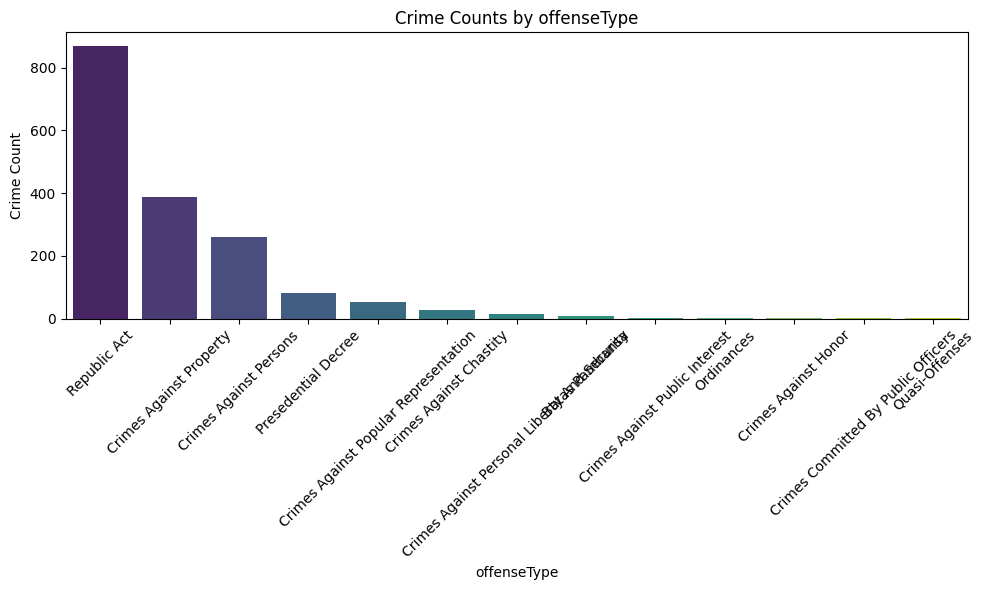

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the crimes by offenseType
crime_counts_by_offenseType = data['offenseType'].value_counts()

# Plot the counts
plt.figure(figsize=(10, 6))
sns.barplot(x=crime_counts_by_offenseType.index, y=crime_counts_by_offenseType.values, palette="viridis")

# Set the title and labels
plt.title('Crime Counts by offenseType')
plt.xlabel('offenseType')
plt.ylabel('Crime Count')

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

In [9]:
# Display crime counts by barangay
print("Crime counts by barangay:")
print(data['offenseType'].value_counts())

Crime counts by barangay:
offenseType
Republic Act                                    869
Crimes Against Property                         387
Crimes Against Persons                          259
Presedential Decree                              83
Crimes Against Popular Representation            52
Crimes Against Chastity                          29
Crimes Against Personal Liberty And Security     16
Batas Pambansa                                    7
Crimes Against Public Interest                    3
Ordinances                                        3
Crimes Against Honor                              1
Crimes Committed By Public Officers               1
Quasi-Offenses                                    1
Name: count, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_13380\2582672245.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crime_counts_by_barangay.index, y=crime_counts_by_barangay.values, palette="viridis")


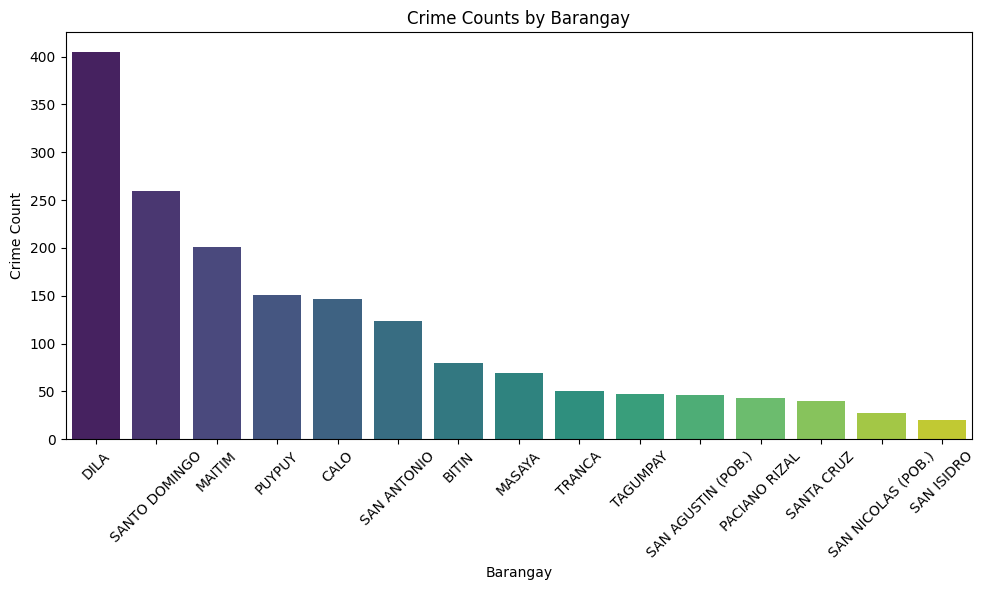

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the crimes by barangay
crime_counts_by_barangay = data['barangay'].value_counts()

# Plot the counts
plt.figure(figsize=(10, 6))
sns.barplot(x=crime_counts_by_barangay.index, y=crime_counts_by_barangay.values, palette="viridis")

# Set the title and labels
plt.title('Crime Counts by Barangay')
plt.xlabel('Barangay')
plt.ylabel('Crime Count')

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_13380\1032464530.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_crime_counts_by_date.index, y=top_10_crime_counts_by_date.values, palette="viridis")


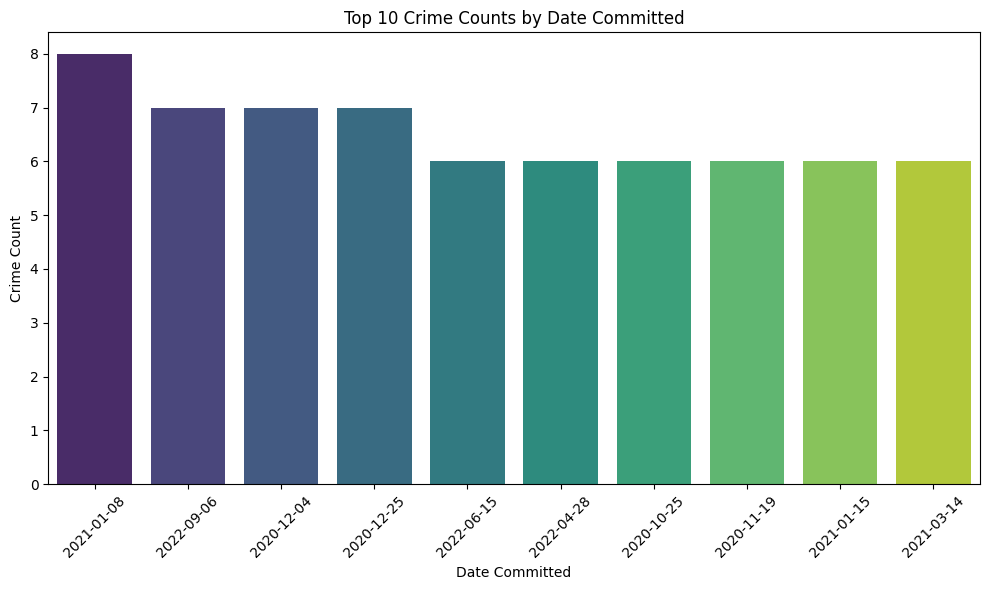

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the crimes by dateCommitted and get the top 10
top_10_crime_counts_by_date = data['dateCommitted'].value_counts().head(10)

# Plot the counts
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_crime_counts_by_date.index, y=top_10_crime_counts_by_date.values, palette="viridis")

# Set the title and labels
plt.title('Top 10 Crime Counts by Date Committed')
plt.xlabel('Date Committed')
plt.ylabel('Crime Count')

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_13380\2249086075.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bottom_10_crime_counts_by_date.index, y=bottom_10_crime_counts_by_date.values, palette="viridis")


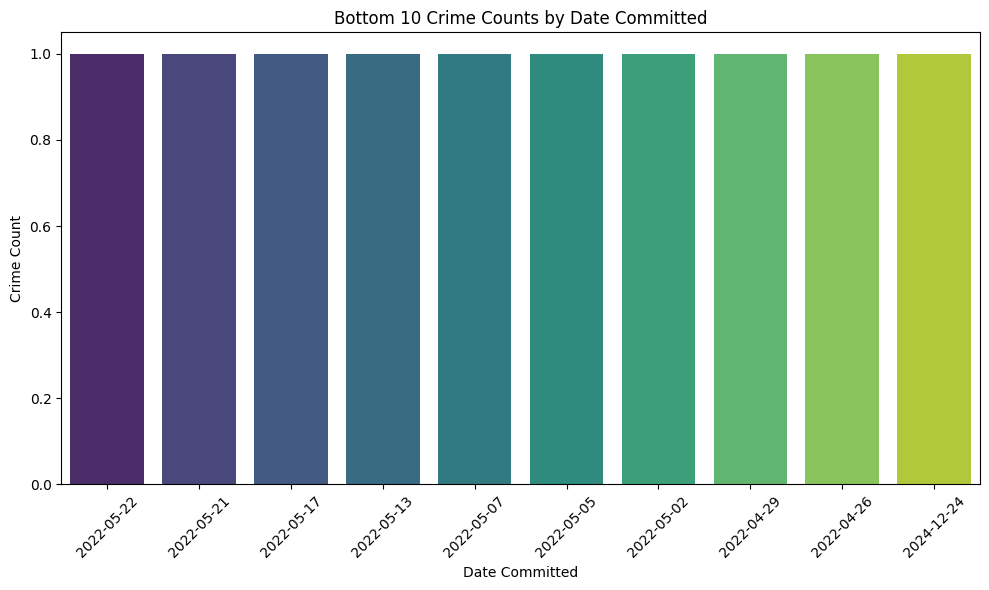

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the crimes by dateCommitted and get the bottom 10
bottom_10_crime_counts_by_date = data['dateCommitted'].value_counts().tail(10)

# Plot the counts
plt.figure(figsize=(10, 6))
sns.barplot(x=bottom_10_crime_counts_by_date.index, y=bottom_10_crime_counts_by_date.values, palette="viridis")

# Set the title and labels
plt.title('Bottom 10 Crime Counts by Date Committed')
plt.xlabel('Date Committed')
plt.ylabel('Crime Count')

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA model summary for BITIN:
                               SARIMAX Results                                
Dep. Variable:                  BITIN   No. Observations:                  917
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -386.073
Date:                Sun, 25 May 2025   AIC                            778.147
Time:                        08:07:03   BIC                            792.607
Sample:                             0   HQIC                           783.666
                                - 917                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0216      0.032     -0.681      0.496      -0.084       0.041
ma.L1         -0.9673      0.007   -133.944      0.000      -0.981      -0.953
sigma2         0.1356

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


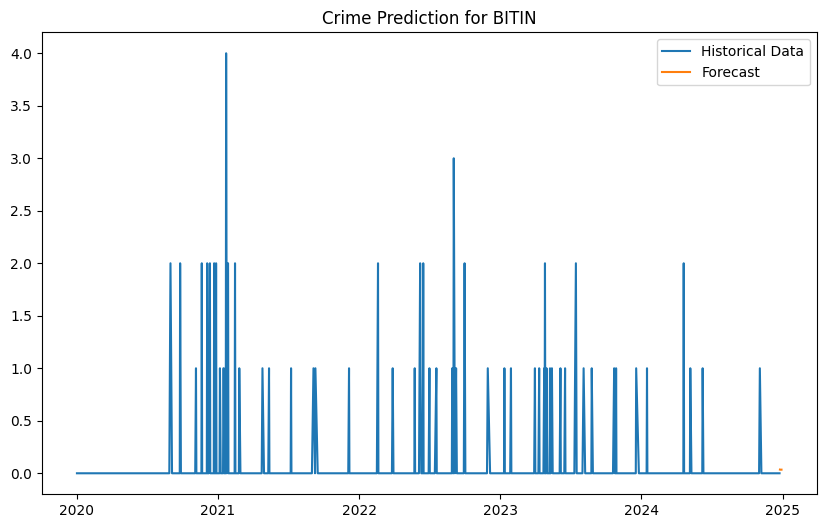

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA model summary for CALO:
                               SARIMAX Results                                
Dep. Variable:                   CALO   No. Observations:                  917
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -660.687
Date:                Sun, 25 May 2025   AIC                           1327.373
Time:                        08:07:05   BIC                           1341.833
Sample:                             0   HQIC                          1332.892
                                - 917                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0282      0.041     -0.685      0.493      -0.109       0.052
ma.L1         -1.0000      0.168     -5.940      0.000      -1.330      -0.670
sigma2         0.2459 

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


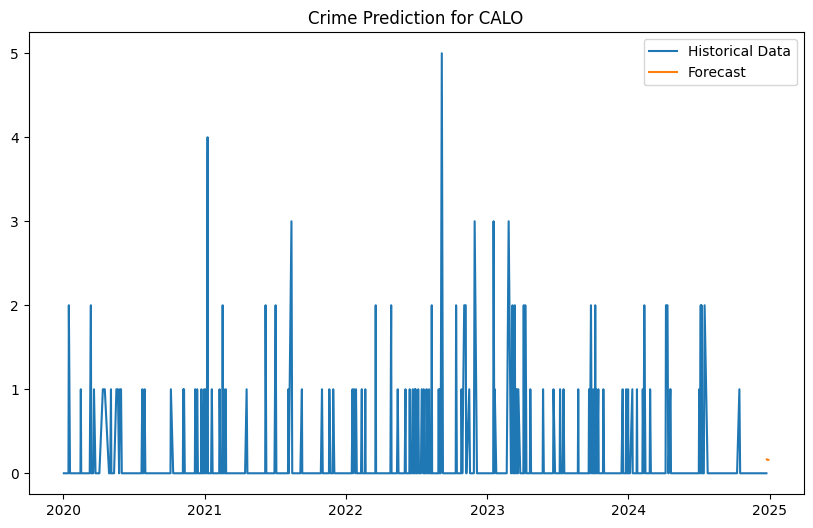

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA model summary for DILA:
                               SARIMAX Results                                
Dep. Variable:                   DILA   No. Observations:                  917
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1039.914
Date:                Sun, 25 May 2025   AIC                           2085.827
Time:                        08:07:06   BIC                           2100.287
Sample:                             0   HQIC                          2091.346
                                - 917                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0705      0.030      2.329      0.020       0.011       0.130
ma.L1         -0.9999      0.261     -3.837      0.000      -1.511      -0.489
sigma2         0.5629 

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


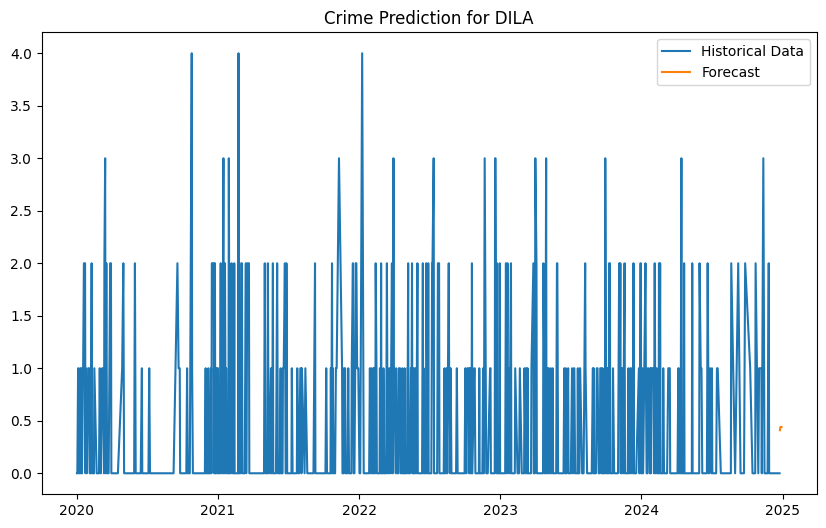

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA model summary for MAITIM:
                               SARIMAX Results                                
Dep. Variable:                 MAITIM   No. Observations:                  917
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -759.632
Date:                Sun, 25 May 2025   AIC                           1525.264
Time:                        08:07:07   BIC                           1539.724
Sample:                             0   HQIC                          1530.783
                                - 917                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0528      0.034     -1.544      0.123      -0.120       0.014
ma.L1         -0.9666      0.008   -121.691      0.000      -0.982      -0.951
sigma2         0.306

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


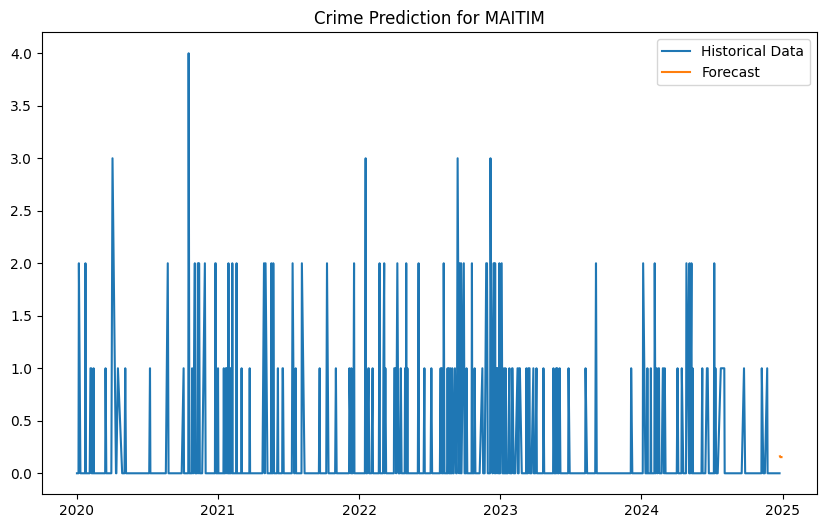

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA model summary for MASAYA:
                               SARIMAX Results                                
Dep. Variable:                 MASAYA   No. Observations:                  917
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -236.528
Date:                Sun, 25 May 2025   AIC                            479.056
Time:                        08:07:08   BIC                            493.516
Sample:                             0   HQIC                           484.575
                                - 917                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0743      0.019      3.947      0.000       0.037       0.111
ma.L1         -0.9962      0.006   -153.510      0.000      -1.009      -0.983
sigma2         0.097

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


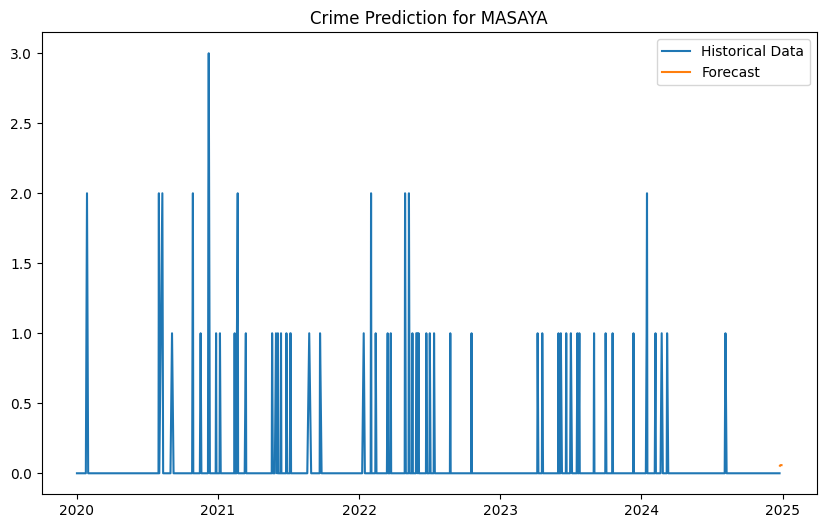

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA model summary for PACIANO RIZAL:
                               SARIMAX Results                                
Dep. Variable:          PACIANO RIZAL   No. Observations:                  917
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -46.474
Date:                Sun, 25 May 2025   AIC                             98.948
Time:                        08:07:09   BIC                            113.408
Sample:                             0   HQIC                           104.467
                                - 917                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0331      0.277     -0.119      0.905      -0.577       0.511
ma.L1         -0.9998      0.049    -20.421      0.000      -1.096      -0.904
sigma2       

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


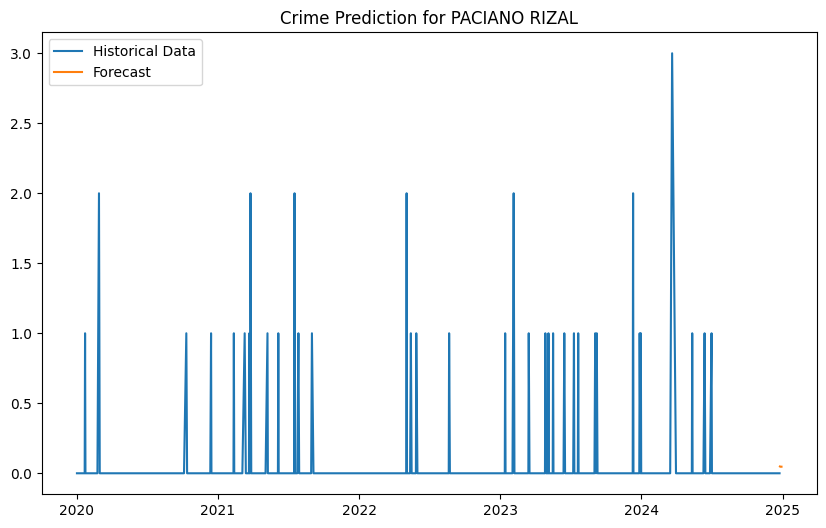

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA model summary for PUYPUY:
                               SARIMAX Results                                
Dep. Variable:                 PUYPUY   No. Observations:                  917
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -641.302
Date:                Sun, 25 May 2025   AIC                           1288.604
Time:                        08:07:10   BIC                           1303.064
Sample:                             0   HQIC                          1294.123
                                - 917                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0197      0.041     -0.476      0.634      -0.101       0.062
ma.L1         -0.9956      0.005   -187.767      0.000      -1.006      -0.985
sigma2         0.236

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


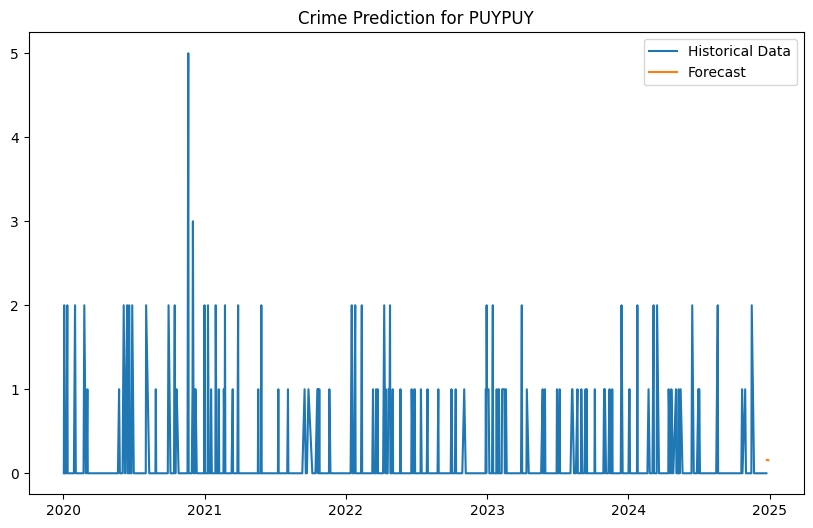

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA model summary for SAN AGUSTIN (POB.):
                               SARIMAX Results                                
Dep. Variable:     SAN AGUSTIN (POB.)   No. Observations:                  917
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -36.761
Date:                Sun, 25 May 2025   AIC                             79.522
Time:                        08:07:12   BIC                             93.982
Sample:                             0   HQIC                            85.041
                                - 917                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0131      0.031      0.423      0.672      -0.047       0.073
ma.L1         -1.0000      0.861     -1.162      0.245      -2.687       0.687
sigma2  

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


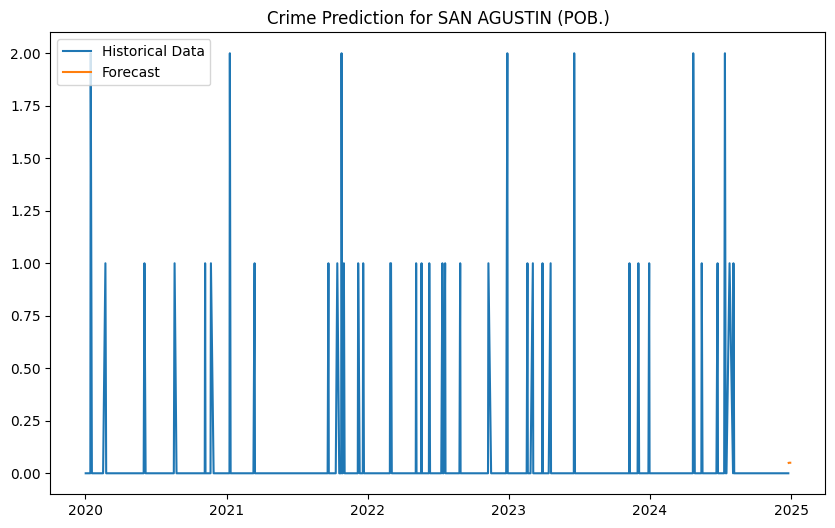

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA model summary for SAN ANTONIO:
                               SARIMAX Results                                
Dep. Variable:            SAN ANTONIO   No. Observations:                  917
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -633.128
Date:                Sun, 25 May 2025   AIC                           1272.257
Time:                        08:07:13   BIC                           1286.717
Sample:                             0   HQIC                          1277.776
                                - 917                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0733      0.018      4.106      0.000       0.038       0.108
ma.L1         -0.9873      0.008   -128.466      0.000      -1.002      -0.972
sigma2         

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


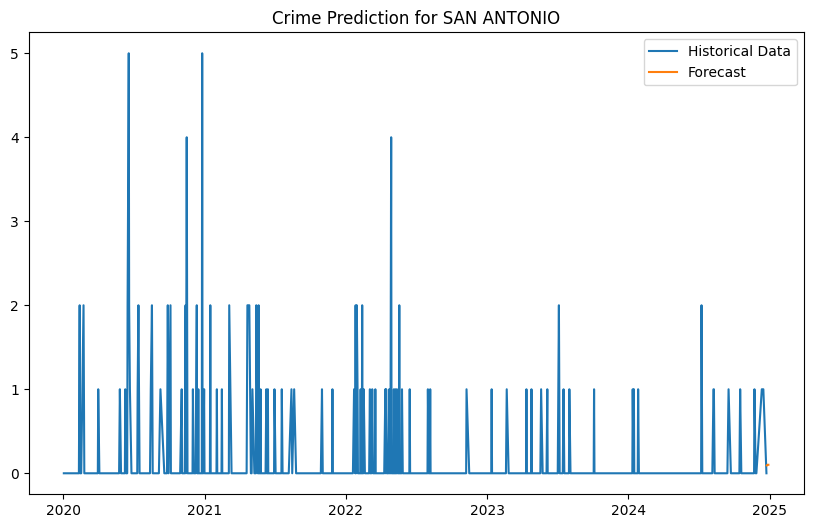

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA model summary for SAN ISIDRO:
                               SARIMAX Results                                
Dep. Variable:             SAN ISIDRO   No. Observations:                  917
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 414.205
Date:                Sun, 25 May 2025   AIC                           -822.409
Time:                        08:07:14   BIC                           -807.949
Sample:                             0   HQIC                          -816.890
                                - 917                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0205      0.409     -0.050      0.960      -0.822       0.781
ma.L1         -0.9971      0.007   -133.425      0.000      -1.012      -0.982
sigma2         0

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


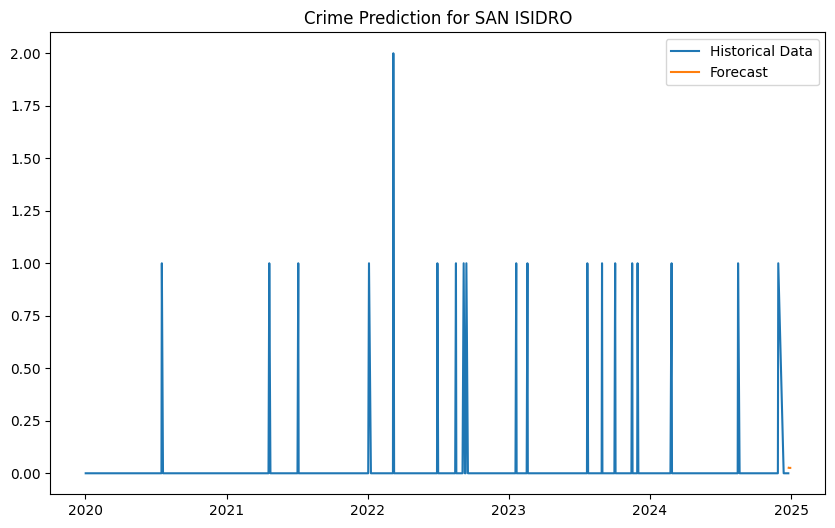

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA model summary for SAN NICOLAS (POB.):
                               SARIMAX Results                                
Dep. Variable:     SAN NICOLAS (POB.)   No. Observations:                  917
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  77.070
Date:                Sun, 25 May 2025   AIC                           -148.139
Time:                        08:07:14   BIC                           -133.679
Sample:                             0   HQIC                          -142.620
                                - 917                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0440      0.022      2.021      0.043       0.001       0.087
ma.L1         -0.9941      0.008   -127.480      0.000      -1.009      -0.979
sigma2  

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


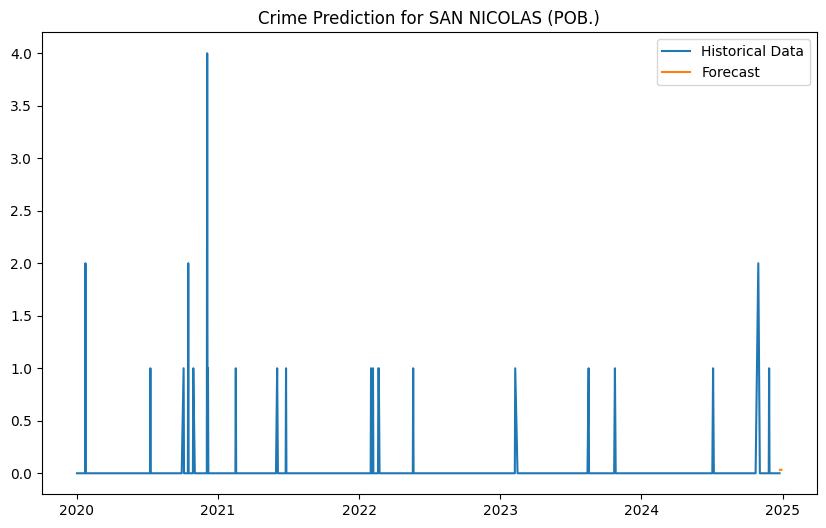

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA model summary for SANTA CRUZ:
                               SARIMAX Results                                
Dep. Variable:             SANTA CRUZ   No. Observations:                  917
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -113.566
Date:                Sun, 25 May 2025   AIC                            233.132
Time:                        08:07:15   BIC                            247.592
Sample:                             0   HQIC                           238.651
                                - 917                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0245      0.196     -0.125      0.901      -0.409       0.360
ma.L1         -1.0000      0.888     -1.126      0.260      -2.740       0.740
sigma2         0

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


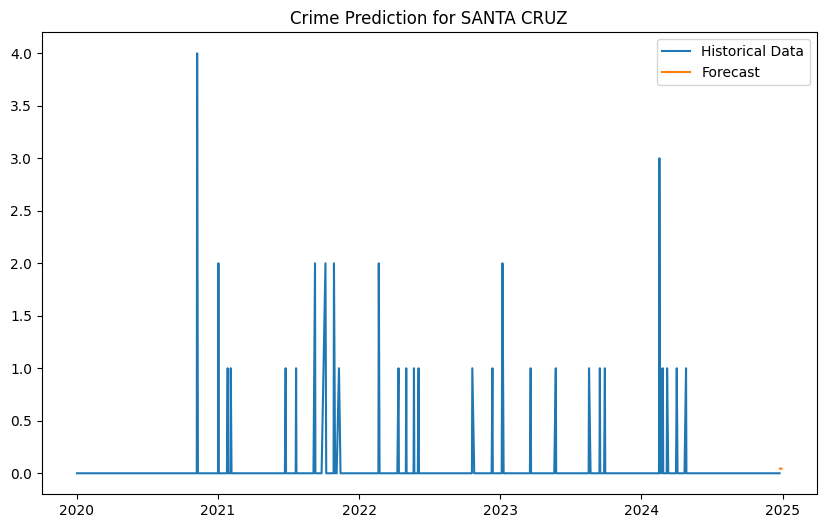

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA model summary for SANTO DOMINGO:
                               SARIMAX Results                                
Dep. Variable:          SANTO DOMINGO   No. Observations:                  917
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -887.503
Date:                Sun, 25 May 2025   AIC                           1781.005
Time:                        08:07:17   BIC                           1795.465
Sample:                             0   HQIC                          1786.524
                                - 917                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0167      0.030      0.559      0.576      -0.042       0.075
ma.L1         -0.9969      0.005   -183.594      0.000      -1.007      -0.986
sigma2       

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


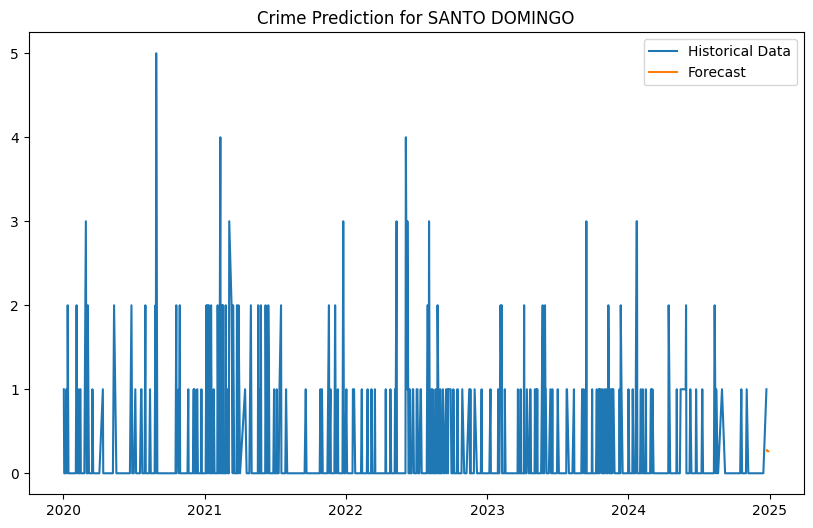

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA model summary for TAGUMPAY:
                               SARIMAX Results                                
Dep. Variable:               TAGUMPAY   No. Observations:                  917
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -139.994
Date:                Sun, 25 May 2025   AIC                            285.988
Time:                        08:07:18   BIC                            300.448
Sample:                             0   HQIC                           291.508
                                - 917                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0102      0.033      0.309      0.757      -0.055       0.075
ma.L1         -0.9730      0.008   -125.826      0.000      -0.988      -0.958
sigma2         0.0

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


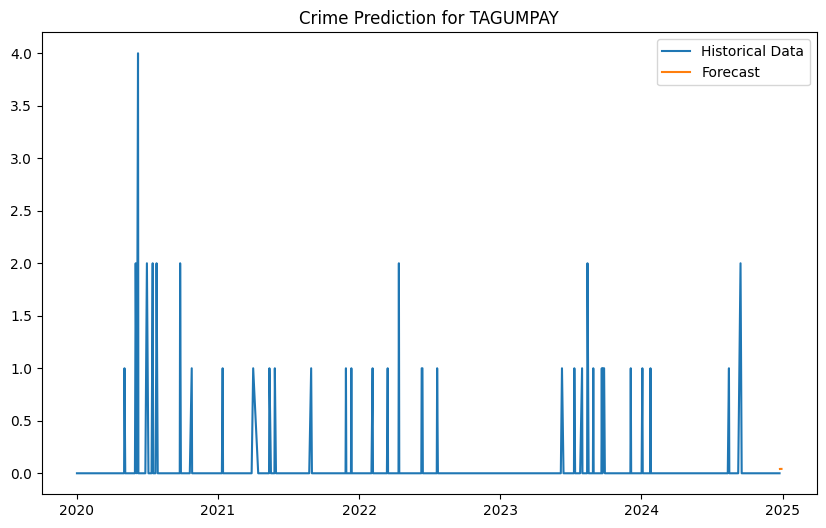

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA model summary for TRANCA:
                               SARIMAX Results                                
Dep. Variable:                 TRANCA   No. Observations:                  917
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -70.654
Date:                Sun, 25 May 2025   AIC                            147.308
Time:                        08:07:19   BIC                            161.768
Sample:                             0   HQIC                           152.827
                                - 917                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0285      0.069     -0.411      0.681      -0.164       0.107
ma.L1         -0.9998      0.110     -9.121      0.000      -1.215      -0.785
sigma2         0.067

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


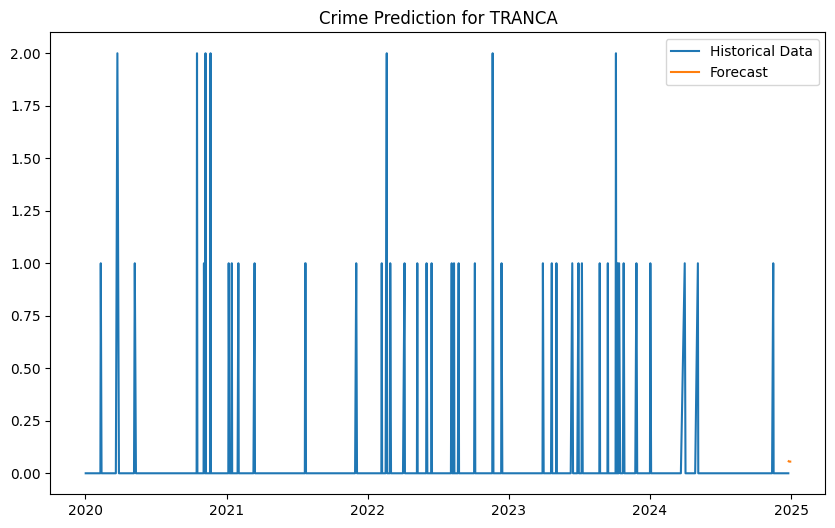

In [13]:
# Time series analysis (for each barangay)
crime_trends = data.groupby(['dateCommitted', 'barangay']).size().unstack(fill_value=0)
for barangay in crime_trends.columns:
    crime_series = crime_trends[barangay]
    model = ARIMA(crime_series, order=(1, 1, 1)) 
    model_fit = model.fit()
    print(f"ARIMA model summary for {barangay}:")
    print(model_fit.summary())

    # Predict for the next 5 days
    forecast = model_fit.forecast(steps=5)
    print(f"Crime forecast for the next 5 days in {barangay}:")
    print(forecast)

    # Visualize prediction
    plt.figure(figsize=(10, 6))
    plt.plot(crime_series.index, crime_series.values, label="Historical Data")
    plt.plot(pd.date_range(crime_series.index[-1], periods=6, freq='D')[1:], forecast, label="Forecast")
    plt.title(f"Crime Prediction for {barangay}")
    plt.legend()
    plt.show()

In [14]:
# Feature engineering
data['is_weekend'] = data['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)
data['recent_crimes'] = data.groupby('barangay')['dateCommitted'].rank(ascending=False)

In [15]:
# Encode categorical data
data_encoded = pd.get_dummies(data[['barangay', 'offense', 'offenseType', 'stageoffelony', 'is_weekend']])
X = data_encoded
y = data[['barangay', 'offense', 'offenseType', 'stageoffelony']]

In [16]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
# Train a Random Forest Classifier
rf_model_barangay = RandomForestClassifier(random_state=42)
rf_model_offense = RandomForestClassifier(random_state=42)
rf_model_offenseType = RandomForestClassifier(random_state=42)
rf_model_stageoffelony = RandomForestClassifier(random_state=42)

rf_model_barangay.fit(X_train, y_train['barangay'])
rf_model_offense.fit(X_train, y_train['offense'])
rf_model_offenseType.fit(X_train, y_train['offenseType'])
rf_model_stageoffelony.fit(X_train, y_train['stageoffelony'])

RandomForestClassifier(random_state=42)

In [18]:
# Predict using the trained models
y_pred_barangay = rf_model_barangay.predict(X_test)
y_pred_offense = rf_model_offense.predict(X_test)
y_pred_offenseType = rf_model_offenseType.predict(X_test)
y_pred_stageoffelony = rf_model_stageoffelony.predict(X_test)

# Print classification reports for each target
print("Classification Report for Barangay Prediction:")
print(classification_report(y_test['barangay'], y_pred_barangay))

print("Classification Report for Offense Prediction:")
print(classification_report(y_test['offense'], y_pred_offense))

print("Classification Report for Offense Type Prediction:")
print(classification_report(y_test['offenseType'], y_pred_offenseType))

print("Classification Report for Stage of Felony Prediction:")
print(classification_report(y_test['stageoffelony'], y_pred_stageoffelony))

Classification Report for Barangay Prediction:
                    precision    recall  f1-score   support

             BITIN       1.00      1.00      1.00        27
              CALO       1.00      1.00      1.00        36
              DILA       1.00      1.00      1.00       123
            MAITIM       1.00      1.00      1.00        61
            MASAYA       1.00      1.00      1.00        22
     PACIANO RIZAL       1.00      1.00      1.00        17
            PUYPUY       1.00      1.00      1.00        33
SAN AGUSTIN (POB.)       1.00      1.00      1.00        19
       SAN ANTONIO       1.00      1.00      1.00        37
        SAN ISIDRO       1.00      1.00      1.00         7
SAN NICOLAS (POB.)       1.00      1.00      1.00        11
        SANTA CRUZ       1.00      1.00      1.00        18
     SANTO DOMINGO       1.00      1.00      1.00        75
          TAGUMPAY       1.00      1.00      1.00        18
            TRANCA       1.00      1.00      1.00   

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{

In [19]:
# Make predictions for all barangays in the dataset
all_predictions_barangay = rf_model_barangay.predict(X)
all_predictions_offense = rf_model_offense.predict(X)
all_predictions_offenseType = rf_model_offenseType.predict(X)
all_predictions_stageoffelony = rf_model_stageoffelony.predict(X)

In [20]:
# Add predictions to the original dataset
data['predicted_barangay'] = all_predictions_barangay
data['predicted_offense'] = all_predictions_offense
data['predicted_offenseType'] = all_predictions_offenseType
data['predicted_stageoffelony'] = all_predictions_stageoffelony

# Show the predictions
print("Predicted barangay, offense, offenseType and stageoffelony for all records:")
print(data[['dateCommitted', 'barangay', 'predicted_barangay', 'offense', 'predicted_offense', 'offenseType', 'predicted_offenseType', 'predicted_stageoffelony']])

Predicted barangay, offense, offenseType and stageoffelony for all records:
     dateCommitted            barangay  predicted_barangay  \
0       2020-01-02       SANTO DOMINGO       SANTO DOMINGO   
1       2020-01-03              PUYPUY              PUYPUY   
2       2020-01-03              PUYPUY              PUYPUY   
3       2020-01-05                DILA                DILA   
4       2020-01-06                DILA                DILA   
...            ...                 ...                 ...   
1706    2024-11-27  SAN NICOLAS (POB.)  SAN NICOLAS (POB.)   
1707    2024-11-28          SAN ISIDRO          SAN ISIDRO   
1708    2024-12-12         SAN ANTONIO         SAN ANTONIO   
1709    2024-12-16         SAN ANTONIO         SAN ANTONIO   
1710    2024-12-24       SANTO DOMINGO       SANTO DOMINGO   

                                                offense  \
0     RECKLESS IMPRUDENCE RESULTING TO PHYSICAL INJU...   
1     COMPREHENSIVE DANGEROUS DRUGS ACT OF 2002 - SA...   
2 

In [21]:
future_features = {
    'is_weekend': [0, 0, 1, 1, 0],
}
future_features_df = pd.DataFrame(future_features)
future_features_df = pd.get_dummies(future_features_df)
future_features_df = future_features_df.reindex(columns=X_train.columns, fill_value=0)

In [22]:
# Predict future barangay and offenseType
future_prediction_barangay = rf_model_barangay.predict(future_features_df)
future_prediction_offense = rf_model_offense.predict(future_features_df)
future_prediction_offenseType = rf_model_offenseType.predict(future_features_df)
future_prediction_stageoffelony = rf_model_stageoffelony.predict(future_features_df)

In [23]:
# Prepare the future predicted data
future_predicted_data = []

In [24]:
current_date = datetime.datetime.now()

for i, (prediction_barangay, prediction_offense, prediction_offenseType, prediction_stageoffelony) in enumerate(zip(future_prediction_barangay, future_prediction_offense, future_prediction_offenseType, future_prediction_stageoffelony)):
    # Find a row with the predicted barangay to extract details
    matching_row = data[data['barangay'] == prediction_barangay].iloc[0]
    region = matching_row['region']
    province = matching_row['province']
    municipal = matching_row['municipal']
    offense = matching_row['offenseType']
    offense_type = matching_row['offense']
    stage_of_felony = matching_row['stageoffelony']
    predicted_timestamp = current_date + datetime.timedelta(days=i+1)
    
    # Append the predicted data
    future_predicted_data.append([
        region,
        province,
        municipal,
        prediction_barangay,
        prediction_offense,
        prediction_offenseType,
        prediction_stageoffelony,
        predicted_timestamp.strftime("%Y-%m-%d %H:%M:%S")
    ])

In [25]:
# Print the formatted future predictions
print("Predicted barangays, offenseTypes, and estimated deployment timestamps for the next 5 days:")
for idx, prediction in enumerate(future_predicted_data):
    print(f"{idx + 1}: {prediction}")

Predicted barangays, offenseTypes, and estimated deployment timestamps for the next 5 days:
1: ['CALABARZON', 'LAGUNA', 'BAY', 'TAGUMPAY', 'FALSIFICATION BY PRIVATE INDIVIDUAL AND USE OF FALSIFIED DOCUMENTS  - RPC Art. 172', 'Crimes Against Persons', 'CONSUMMATED', '2025-05-26 08:07:23']
2: ['CALABARZON', 'LAGUNA', 'BAY', 'TAGUMPAY', 'FALSIFICATION BY PRIVATE INDIVIDUAL AND USE OF FALSIFIED DOCUMENTS  - RPC Art. 172', 'Crimes Against Persons', 'CONSUMMATED', '2025-05-27 08:07:23']
3: ['CALABARZON', 'LAGUNA', 'BAY', 'MASAYA', 'CITY/MUNICIPAL ORDINANCE -', 'Crimes Against Persons', 'CONSUMMATED', '2025-05-28 08:07:23']
4: ['CALABARZON', 'LAGUNA', 'BAY', 'MASAYA', 'CITY/MUNICIPAL ORDINANCE -', 'Crimes Against Persons', 'CONSUMMATED', '2025-05-29 08:07:23']
5: ['CALABARZON', 'LAGUNA', 'BAY', 'TAGUMPAY', 'FALSIFICATION BY PRIVATE INDIVIDUAL AND USE OF FALSIFIED DOCUMENTS  - RPC Art. 172', 'Crimes Against Persons', 'CONSUMMATED', '2025-05-30 08:07:23']


In [26]:
for idx, prediction in enumerate(future_predicted_data):
    region = prediction[0]
    province = prediction[1]
    municipal = prediction[2]
    barangay = prediction[3]
    offense = prediction[4]
    offenseType = prediction[5]
    stageoffelony = prediction[6]
    date_committed = prediction[7].split()[0]
    time_committed = prediction[7].split()[1]
    timestamp = prediction[7]
    
    # Generate the SQL insert command
    sql_command = f"""
    INSERT INTO future_predictions (region, province, municipal, barangay, dateCommitted, timeCommitted, offense, offenseType, stageoffelony, predicted_timestamp)
    VALUES ('{region}', '{province}', '{municipal}', '{barangay}', '{date_committed}, '{time_committed}', '{offense}', '{offenseType}', '{stageoffelony}', '{timestamp}');
    """
    print(sql_command)


    INSERT INTO future_predictions (region, province, municipal, barangay, dateCommitted, timeCommitted, offense, offenseType, stageoffelony, predicted_timestamp)
    VALUES ('CALABARZON', 'LAGUNA', 'BAY', 'TAGUMPAY', '2025-05-26, '08:07:23', 'FALSIFICATION BY PRIVATE INDIVIDUAL AND USE OF FALSIFIED DOCUMENTS  - RPC Art. 172', 'Crimes Against Persons', 'CONSUMMATED', '2025-05-26 08:07:23');
    

    INSERT INTO future_predictions (region, province, municipal, barangay, dateCommitted, timeCommitted, offense, offenseType, stageoffelony, predicted_timestamp)
    VALUES ('CALABARZON', 'LAGUNA', 'BAY', 'TAGUMPAY', '2025-05-27, '08:07:23', 'FALSIFICATION BY PRIVATE INDIVIDUAL AND USE OF FALSIFIED DOCUMENTS  - RPC Art. 172', 'Crimes Against Persons', 'CONSUMMATED', '2025-05-27 08:07:23');
    

    INSERT INTO future_predictions (region, province, municipal, barangay, dateCommitted, timeCommitted, offense, offenseType, stageoffelony, predicted_timestamp)
    VALUES ('CALABARZON', 'LAGUNA', 

In [27]:
# import requests
# import json

# # Your API endpoint
# url = 'http://localhost/smartpolicesystem/backend/api/v1/incident'

# # Prepare the headers for the POST request
# headers = {'Content-Type': 'application/json'}

# # Print and send data to the API
# print("Sending predictions to the API for insertion:")
# for idx, prediction in enumerate(future_predicted_data):
#     region = prediction[0]
#     province = prediction[1]
#     municipal = prediction[2]
#     barangay = prediction[3]
#     offense = prediction[4]
#     offenseType = prediction[5]
#     stageoffelony = prediction[6]
#     timestamp = prediction[7]
    
#     # Prepare the payload
#     payload = {
#         'region': region,  
#         'province': province,  
#         'municipal': municipal,  
#         'barangay': barangay,
#         'dateCommitted': timestamp.split()[0],  
#         'timeCommitted': timestamp.split()[1],  
#         'stageoffelony': stageoffelony,
#         'offense': offense,
#         'offenseType': offenseType
#     }

#     # Send the POST request to the API
#     response = requests.post(url, headers=headers, data=json.dumps(payload))

#     # Check the response from the API
#     if response.status_code == 200:
#         print(f"Prediction {idx + 1} inserted successfully.")
#     else:
#         print(f"Failed to insert prediction {idx + 1}. Error: {response.status_code}")
#         # Print the response content to see the error message
#         print("Error message:", response.text)


C:\Users\User\AppData\Local\Temp\ipykernel_13380\2967677830.py:6: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been prov

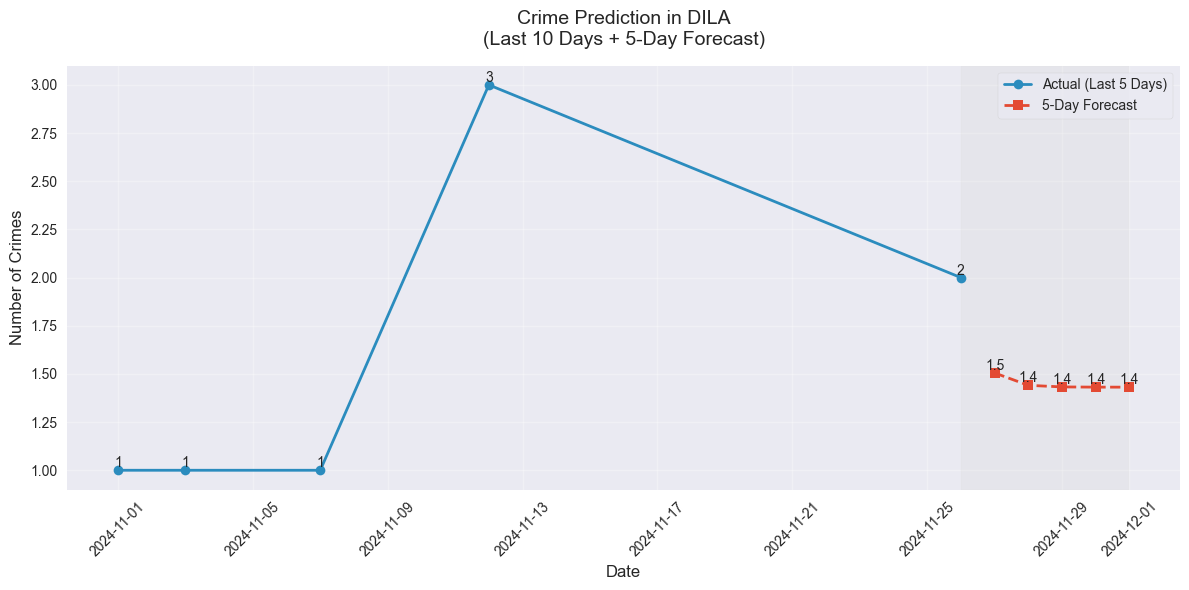

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\User

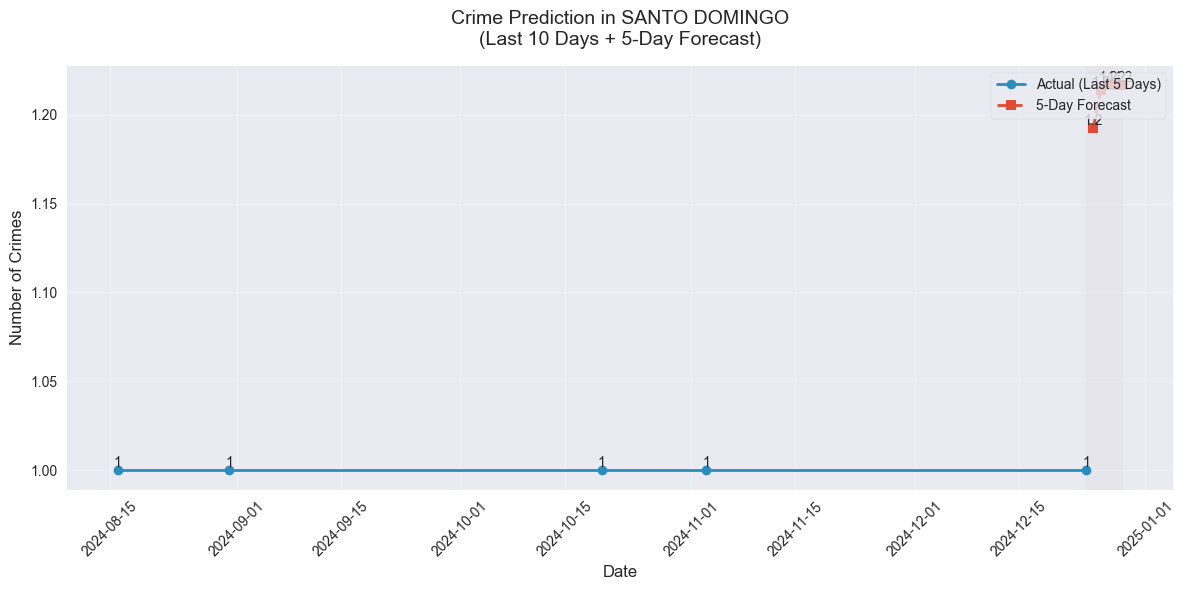

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\User

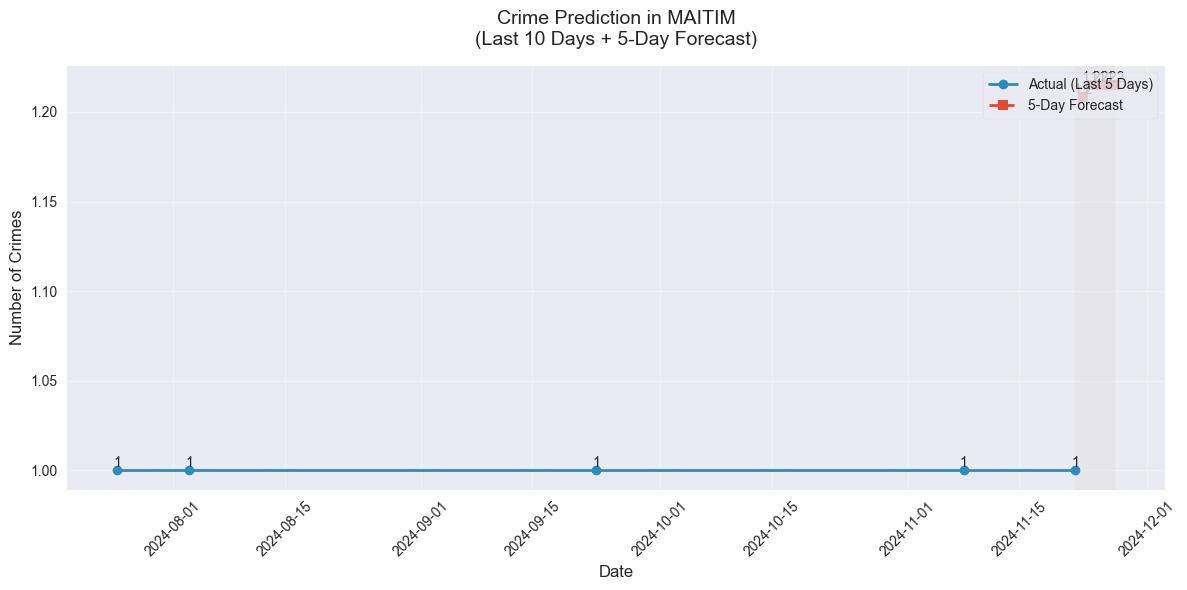

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\User

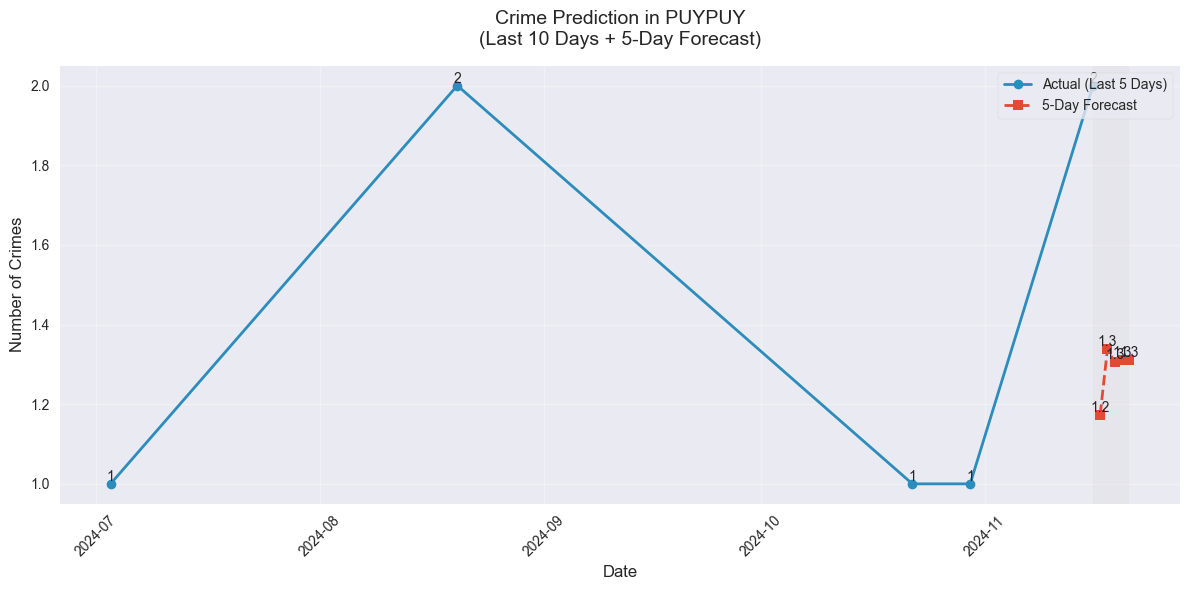

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\User

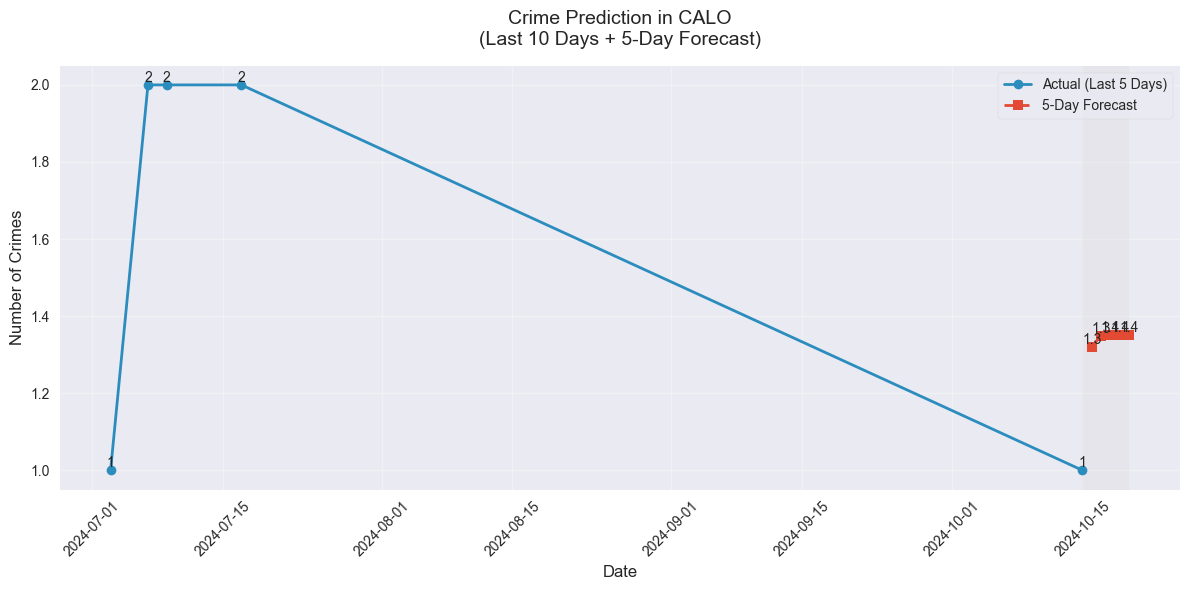

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\User

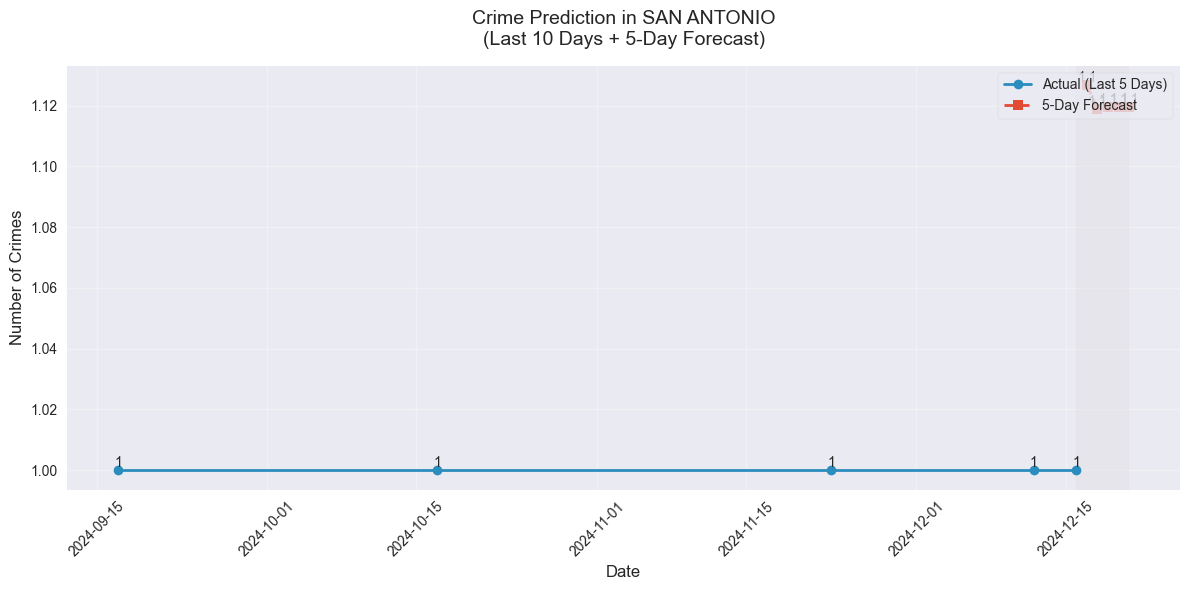

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\User

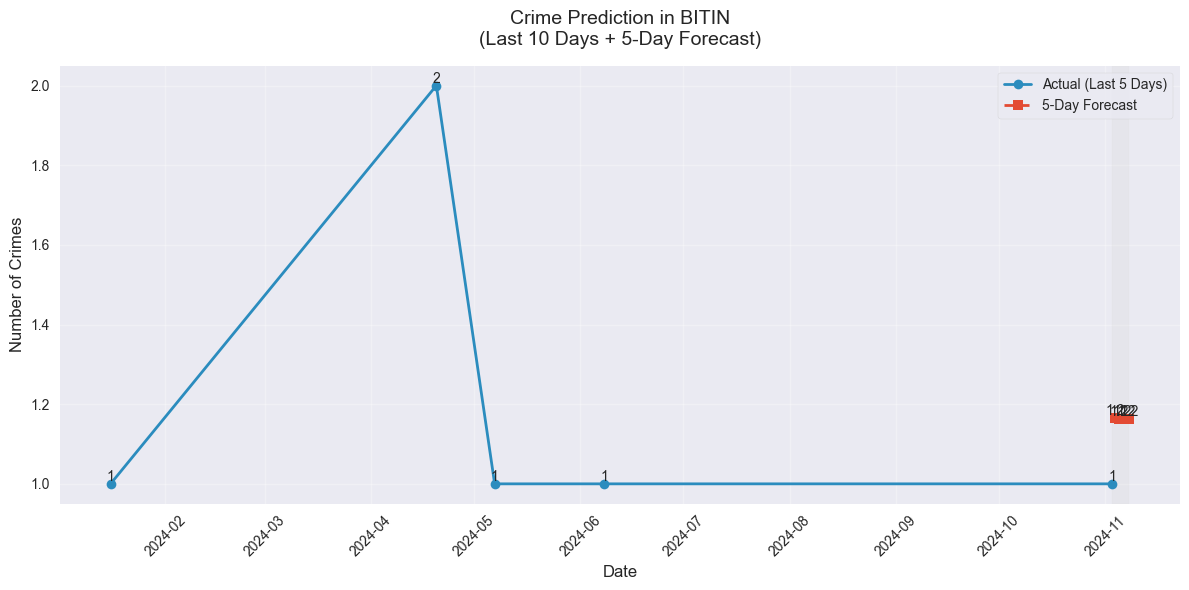

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\User

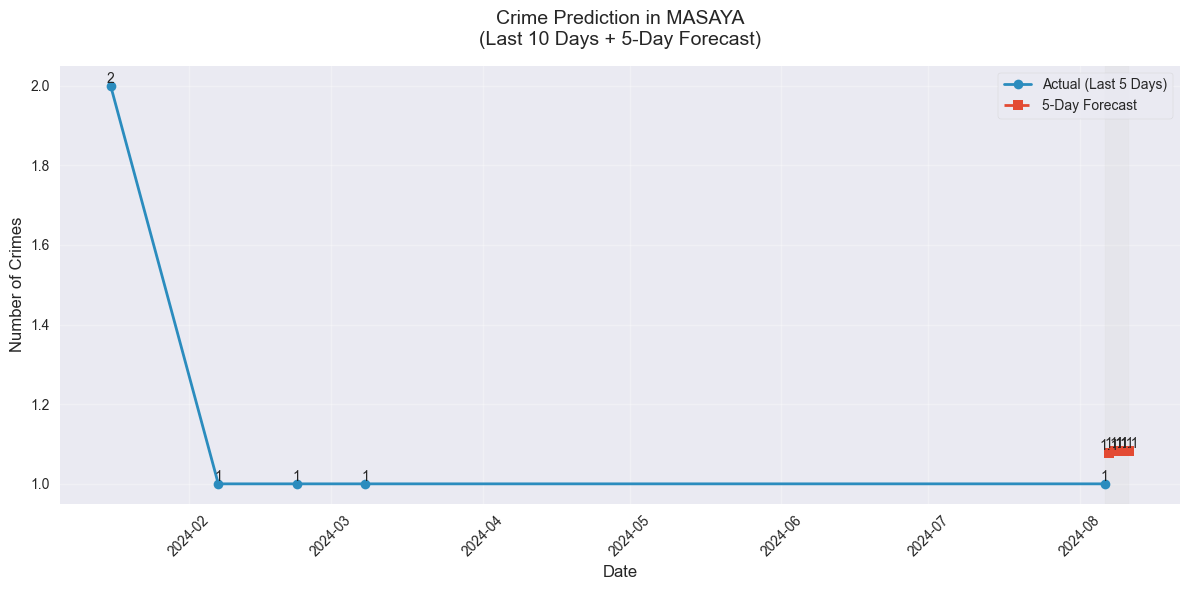

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\User

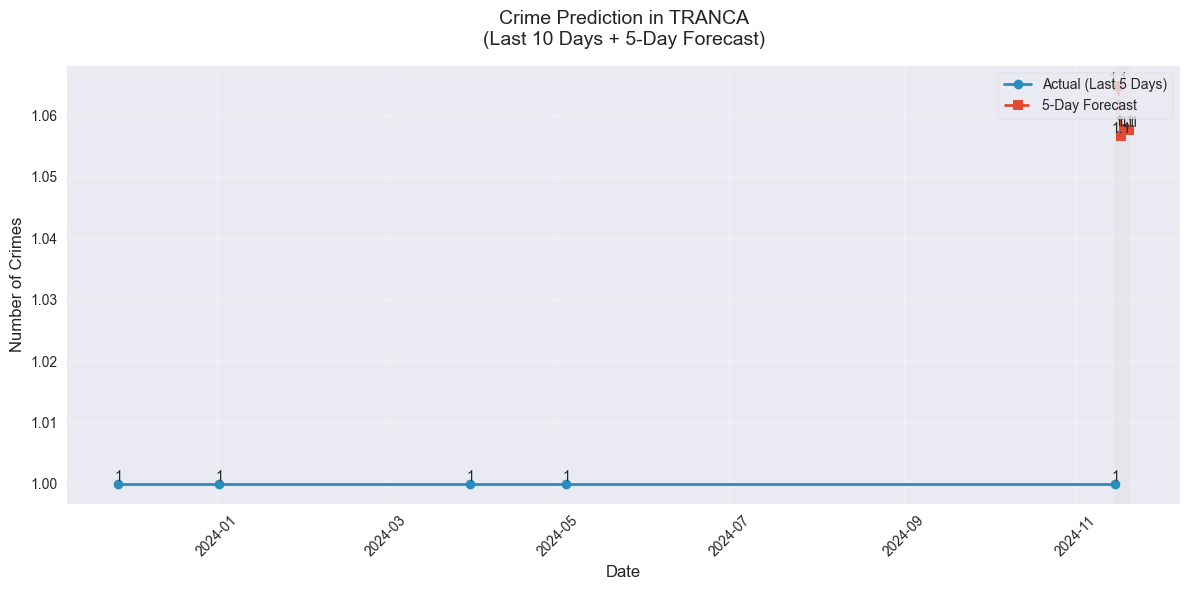

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\User

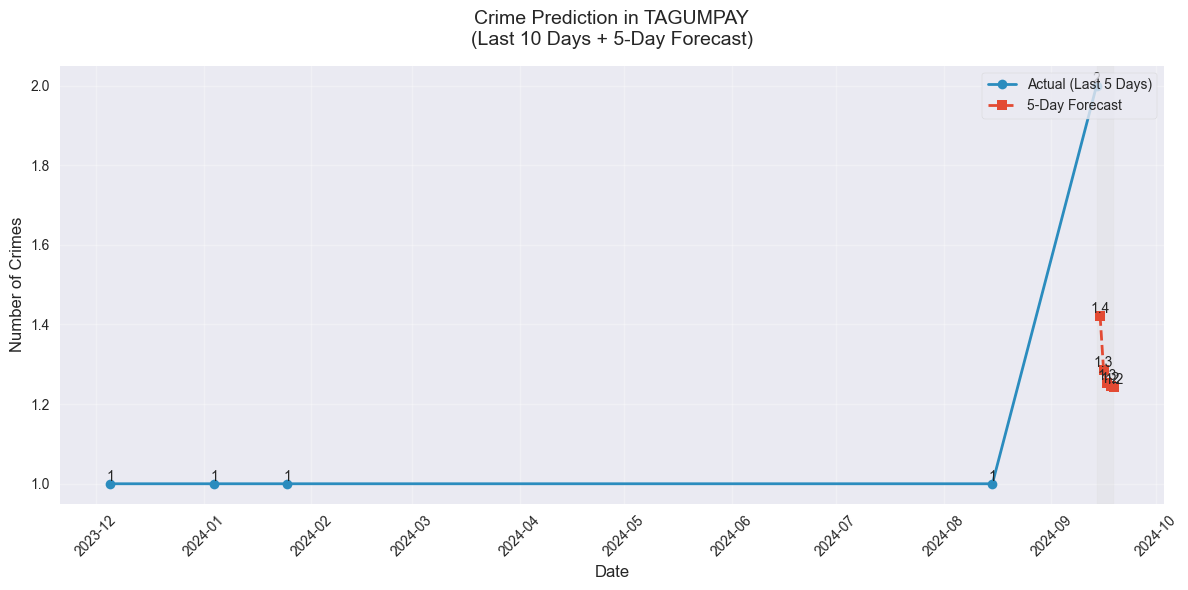

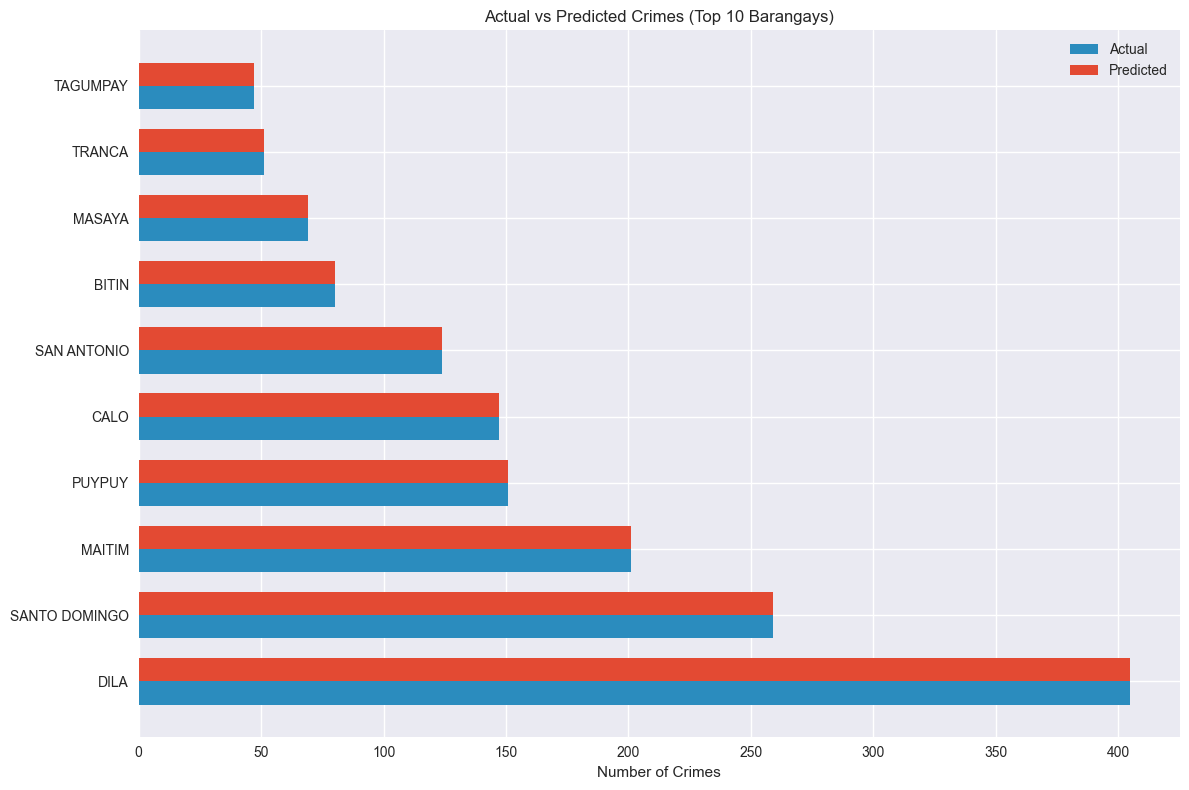

In [41]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Set style
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (12, 6)

# Get top N barangays by crime count (adjust as needed)
top_barangays = data['barangay'].value_counts().nlargest(10).index

# 1. ARIMA Forecast Visualization (Last 10 points + forecast)
for barangay in top_barangays:
    # Filter data for this barangay
    barangay_data = data[data['barangay'] == barangay]
    crime_series = barangay_data.groupby('dateCommitted').size()
    
    # Get last 10 data points
    last_10 = crime_series[-5:]
    
    # Fit ARIMA model
    model = ARIMA(crime_series, order=(1, 1, 1))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=5)
    forecast_dates = pd.date_range(crime_series.index[-1], periods=6, freq='D')[1:]
    
    # Create plot
    plt.figure()
    
    # Plot last 10 actual points
    plt.plot(last_10.index, last_10.values, 
             marker='o', linestyle='-', color='#2b8cbe', 
             label='Actual (Last 5 Days)', linewidth=2)
    
    # Plot forecast
    plt.plot(forecast_dates, forecast, '--', marker='s', 
             color='#e34a33', linewidth=2, 
             label='5-Day Forecast')
    
    # Highlight forecast area
    plt.axvspan(last_10.index[-1], forecast_dates[-1], 
                color='lightgray', alpha=0.2)
    
    # Add value labels
    for x, y in zip(last_10.index, last_10.values):
        plt.text(x, y, f'{y}', ha='center', va='bottom')
    
    for x, y in zip(forecast_dates, forecast):
        plt.text(x, y, f'{y:.1f}', ha='center', va='bottom')
    
    # Formatting
    plt.title(f'Crime Prediction in {barangay}\n(Last 10 Days + 5-Day Forecast)', 
              fontsize=14, pad=15)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Number of Crimes', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(frameon=True, loc='upper right')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 2. Actual vs Predicted Comparison (Top 10 Barangays)
plt.figure(figsize=(12, 8))

# Prepare data
comparison_data = []
for barangay in top_barangays:
    actual = sum(data['barangay'] == barangay)
    predicted = sum(data['predicted_barangay'] == barangay)
    comparison_data.append({'Barangay': barangay, 'Actual': actual, 'Predicted': predicted})

comparison_df = pd.DataFrame(comparison_data)

# Plot
bar_width = 0.35
index = np.arange(len(top_barangays))

plt.barh(index - bar_width/2, comparison_df['Actual'], bar_width,
         color='#2b8cbe', label='Actual')
plt.barh(index + bar_width/2, comparison_df['Predicted'], bar_width,
         color='#e34a33', label='Predicted')

# Add labels
plt.yticks(index, top_barangays)
plt.xlabel('Number of Crimes')
plt.title('Actual vs Predicted Crimes (Top 10 Barangays)')
plt.legend()

plt.tight_layout()
plt.show()